<a href="https://colab.research.google.com/github/takumaosada/COVID-19-Basic-Analysis/blob/master/signate_covid19_case_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの読み込み

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install japanize_matplotlib
!pip install category_encoders
import japanize_matplotlib
import category_encoders as ce
import gspread
import re
import itertools
from oauth2client.client import GoogleCredentials
from google.colab import auth
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [3]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1VLSA8q2zPCbaTDXXcMsxK0HRZlFRVH7_x0rLd4Z7Jk8/edit#gid=960903158'
book = gc.open_by_url(singatecasefilelink)
casedata = book.worksheet('罹患者').get_all_values()
casedf = pd.DataFrame(casedata)

In [4]:
#データフレームを整理していく
area_dict = dict(zip(casedf.index, casedf.iloc[0]))
renamed_df = casedf.rename(columns=area_dict)
df = renamed_df.drop(0)
df =df.drop_duplicates()
df.drop(df.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
16156,50,1,50-1,,,,中部国際空港,,,,,,,,,,,,,,,,,,0,0,,,
16157,51,27,51-27,,2020/03/27,,関西国際空港,不明,,20 - 29,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16158,51,28,51-28,,2020/03/27,,関西国際空港,兵庫県,,非公表,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16159,51,52,51-52,,2020/03/30,,関西国際空港,不明,,30 - 39,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29ドイツから帰国,0,0,,,
16160,51,53,51-53,,2020/03/30,,関西国際空港,不明,,40 - 49,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29オランダから帰国,0,0,,,


# データの確認

In [5]:
df.describe()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
count,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161
unique,51,5175,16158,218,176,178,51,73,791,12,6,121,8,6,6,5995,1812,2907,3984,226,9,4,3232,1336,2,2,1792,3141,229
top,13,1,44-40,非公表,,2020/04/11,東京都,東京都,,50 - 59,男性,,,,,,,,,,,,,,0,0,,,
freq,5162,47,2,5205,4784,674,5162,3836,4638,2636,8682,6541,9412,8836,11928,8179,10814,9974,8403,12728,10125,10885,4091,12960,11874,15934,12368,12369,13890


In [6]:
# nullの値があるかどうか確認
df.isnull().sum()

都道府県コード                  0
症例番号                     0
都道府県症例番号                 0
発症日                      0
確定日                      0
公表日                      0
受診都道府県                   0
居住都道府県                   0
居住市区町村                   0
年代                       0
性別                       0
職業                       0
ステータス                    0
退院済ﾌﾗｸﾞ                  0
基礎疾患ﾌﾗｸﾞ                 0
症状・経過                    0
症状一覧                     0
行動歴                      0
濃厚接触者状況                  0
濃厚接触場所                   0
海外渡航歴ﾌﾗｸﾞ                0
ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ    0
情報源                      0
備考                       0
罹患者関係_記入済ﾌﾗｸﾞ            0
罹患者トランザクション_記入済ﾌﾗｸﾞ      0
Relation1                0
Relation2                0
Transaction              0
dtype: int64

In [7]:
# naの値があるかどうか確認
df.isna().sum()

都道府県コード                  0
症例番号                     0
都道府県症例番号                 0
発症日                      0
確定日                      0
公表日                      0
受診都道府県                   0
居住都道府県                   0
居住市区町村                   0
年代                       0
性別                       0
職業                       0
ステータス                    0
退院済ﾌﾗｸﾞ                  0
基礎疾患ﾌﾗｸﾞ                 0
症状・経過                    0
症状一覧                     0
行動歴                      0
濃厚接触者状況                  0
濃厚接触場所                   0
海外渡航歴ﾌﾗｸﾞ                0
ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ    0
情報源                      0
備考                       0
罹患者関係_記入済ﾌﾗｸﾞ            0
罹患者トランザクション_記入済ﾌﾗｸﾞ      0
Relation1                0
Relation2                0
Transaction              0
dtype: int64

# データクリーニング


In [8]:
#性別でのデータクリーニングを行う
df = df[(df['性別'] == "男性") | (df['性別'] == '女性')]
#年代でのデータクリーニングを行う
df = df[(df['年代'] != "51 - 59") & (df['年代'] != '非公表') & (df['年代'] != '')]
#海外渡航歴でのデータクリーニングを行う
df["海外渡航歴ﾌﾗｸﾞ"] = df["海外渡航歴ﾌﾗｸﾞ"].str.replace("非公表", "").str.replace("１", "1").str.replace("０", "0").str.replace("他自治体で調査中", "").str.replace("千葉県で調査中", "").str.replace("不明", "")
#ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞでのデータクリーニングを行う
df["ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ"] = df["ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ"].str.replace("非公表", "").str.replace("１", "1")

In [9]:
for column_name, item in df.iteritems():
    print(column_name, type(column_name))
    print(df[column_name].value_counts())
    print('========================\n')

都道府県コード <class 'str'>
13    5143
27    1778
14    1282
11     998
1      982
12     753
28     698
40     665
23     508
26     351
17     293
16     212
8      168
21     151
10     149
34     147
47     142
18     122
4       88
15      82
25      82
7       81
38      79
39      74
29      74
6       66
9       55
30      54
20      53
22      49
44      49
19      48
43      47
41      45
24      45
37      28
2       27
32      24
35      21
49      19
42      17
5       16
45      16
33      14
48       8
46       6
36       5
51       3
31       3
Name: 都道府県コード, dtype: int64

症例番号 <class 'str'>
1        46
2        45
6        44
3        44
4        44
         ..
2594      1
a0101     1
3574      1
4496      1
1834      1
Name: 症例番号, Length: 5159, dtype: int64

都道府県症例番号 <class 'str'>
44-40      2
21-150     2
12-621     2
12-566     1
11-698     1
          ..
11-100     1
16-157     1
1-291      1
14-1003    1
13-4503    1
Name: 都道府県症例番号, Length: 15817, dtype: int64

発症日 <cla

In [10]:
#性別をencodeする
import category_encoders as ce
df_gender = df['性別']
list_cols = ['性別']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['性別'] = ce_ohe.fit_transform(df_gender)

In [11]:
#受診都道府県をencodeする
df_city = df['受診都道府県']
list_cols = ['受診都道府県']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['受診都道府県'] = ce_ohe.fit_transform(df_city)

In [12]:
#居住都道府県をencodeする
df_city = df['居住都道府県']
list_cols = ['居住都道府県']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['居住都道府県'] = ce_ohe.fit_transform(df_city)

In [13]:
#年代をencodeする
df_age = df['年代']
list_cols = ['年代']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['年代'] = ce_ohe.fit_transform(df_age)

In [14]:
#ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞをencodeする
df_diamond = df['ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ']
list_cols = ['ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ'] = ce_ohe.fit_transform(df_diamond)

In [15]:
df_foreign = df['海外渡航歴ﾌﾗｸﾞ']
#海外渡航歴ﾌﾗｸﾞをencodeする
list_cols = ['海外渡航歴ﾌﾗｸﾞ']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['海外渡航歴ﾌﾗｸﾞ'] = ce_ohe.fit_transform(df_foreign)

# PairPlotで相関を確認する

In [16]:
# sns.pairplot(df)

In [17]:
#職業とステータスの関係性
job_status_df = df[['職業', 'ステータス']]
job_status_df = job_status_df.groupby('職業').filter(lambda x: len(x) > 100)

df_status = job_status_df['ステータス']
list_cols = ['ステータス']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
job_status_df['ステータス'] = ce_ohe.fit_transform(df_status)

job_status_df['ステータス'] = job_status_df['ステータス'].astype(float)

In [18]:
# fig, axs = plt.subplots(15, 1, figsize=(10, 10))
# for count, (index, value) in enumerate(job_status_df['職業'].value_counts().iteritems(), 1):
#   title = str(index) + ' (標本数: ' + str(value) +  ")"
#   dataframe = job_status_df[job_status_df['職業'] == index]
#   axs[count].set_title(title)
#   axs[count].pie(dataframe["ステータス"])

# plt.show()

# Xgboostを用いた分析

## 症状のデータの読み込み

In [19]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1tnxt17rtmFnG4UNX8DXVXGUhCcL7-cXHE3hhoOpvfsk/edit#gid=577718303'
symptom_book = gc.open_by_url(singatecasefilelink)
symptom_data = symptom_book.worksheet('症状').get_all_values()
symptomdf = pd.DataFrame(symptom_data)

In [20]:
area_dict = dict(zip(symptomdf.index, symptomdf.iloc[0]))
renamed_df = symptomdf.rename(columns=area_dict)
symptomdf = renamed_df.drop(0)
symptomdf =symptomdf.drop_duplicates()
symptomdf.drop(symptomdf.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
53560,27,1804,27-1804,非公表,-,-,-
53562,27,1805,27-1805,非公表,-,-,-
53564,27,1806,27-1806,非公表,-,-,-
53566,27,1807,27-1807,非公表,-,-,-
53568,27,1808,27-1808,非公表,-,-,-


In [21]:
symptomdf = symptomdf[(symptomdf['症状'] != "-")]

In [22]:
symptomdf

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
2,,,,,2020/01/26,icd=R05;咳,1
3,,,,,2020/01/26,icd=R509;発熱,1
4,,,,,2020/01/27,icd=J189;肺炎,1
5,,,,,2020/01/27,受診,1
6,,,,,2020/01/27,入院,1
...,...,...,...,...,...,...,...
52415,,,,,3日,入院,
52419,,,,,20日,icd=J310;鼻汁,
52455,,,,,2020/05/13,icd=J029;咽頭痛,
52458,,,,,16日,icd=R431;嗅覚異常,


In [23]:
symptoms = symptomdf["症状"].unique()
symptoms_list = list()
for element in symptoms:
  elements = re.split('[;，]', element)
  symptoms_list.append(elements)

In [24]:
unique_symptons_list = list(itertools.chain.from_iterable(symptoms_list))
unique_symptons_list = list(set(unique_symptons_list))

In [25]:
#不要な要素を取り除く
cleaned_symptoms_list = list()
for element in unique_symptons_list:
  if not ("icd" in element or "受診" in element or "退院" in element):
      cleaned_symptoms_list.append(element)

In [26]:
cleaned_symptoms_list

['',
 '心不全',
 'かぜ',
 '胸やけ',
 '腹部不快感',
 '誤嚥性肺炎',
 'くしゃみ',
 '咳',
 '前胸部痛',
 '特発性拡張型心筋症',
 '口渇症',
 '腰腹痛',
 '湿疹',
 '振戦',
 '血尿',
 '微熱',
 '検診',
 '胃痛',
 '四肢しびれ',
 '心配',
 '耳痛症',
 '胸部異常陰影',
 '関節痛',
 '下腹痛',
 '頭重感',
 '嚥下障害',
 '胃腸疾患',
 '頻尿症',
 '末梢循環障害',
 '結膜充血',
 '呼吸促迫',
 '過剰喀痰',
 '鼻閉',
 '倦怠感',
 '疼痛',
 '後頭部痛',
 '筋肉痛',
 '頚部腫脹',
 '麻疹',
 '胆石性急性胆のう炎',
 'インフルエンザ',
 '心肺停止',
 '口内炎',
 'コロナウイルス感染症',
 '感冒',
 '悪寒戦慄',
 '食欲不振',
 '老衰',
 'そう痒',
 '窒息感',
 '結膜炎',
 '鼻炎',
 '労作時呼吸困難',
 '咳喘息',
 '下肢しびれ',
 '意識消失',
 'ウイルス感染症',
 '頭痛',
 '乏尿',
 '高血圧症',
 'よう',
 '摂食障害',
 '多尿',
 '肩部痛',
 '喘鳴',
 '聴覚異常',
 'つかえ感',
 '鼻閉感',
 '高熱',
 '意識障害',
 '咽喉頭異常感症',
 '脂質異常症',
 'アデノウイルス感染症',
 '項部腫脹',
 '背部痛',
 '嗅覚異常',
 '扁桃炎',
 '喉頭痛',
 '片頭痛',
 '嗄声',
 '呼吸不全',
 '聴覚障害',
 '筋力低下',
 '腎不全',
 '急性鼻炎',
 '発音障害',
 '膿性痰',
 '気管支炎',
 '鼻痛',
 '血腫',
 '花粉症',
 '腹痛症',
 '胸内苦悶',
 'ほてり',
 '尿路感染症',
 '胸部不快感',
 '乾性咳',
 '嗅覚障害',
 '下痢症',
 '不明熱',
 '起立性眩暈',
 '頚部痛',
 '味覚減退症',
 '肺野異常陰影',
 '疲労感',
 '発汗障害',
 '鼻汁',
 '味覚障害',
 '動悸',
 '入院',
 '摂食機能障害',
 '脱水症',
 '息切れ',
 '味覚異常',
 '歯痛',
 '神経痛',
 

## データの整理

In [27]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output

In [28]:
df_new = df[["都道府県コード", "年代", "性別", "ステータス", "症状一覧"]]

In [29]:
# ステータスは`非公開`や``をdropし、死亡を４、重症を3、中等症を２、軽症、無症状を1とする
df_new = df_new[(df['ステータス'] == "重症") | (df['ステータス'] == '軽症') | (df['ステータス'] == '死亡') | (df['ステータス'] == '無症状') | (df['ステータス'] == '中等症')]
df_new["ステータス"] = df_new["ステータス"].str.replace("重症", "3").str.replace("死亡", "4").str.replace("中等症", "2").str.replace("軽症", "1").str.replace("無症状", "1")
df_new["ステータス"]  =df_new["ステータス"].astype(int)

In [30]:
# 症状一覧で`非公開`や``をdropし、発熱・咳・頭痛・倦怠感があるかどうかのフラグを作成する
df_new = df_new[(df['症状一覧'] != "") & (df['症状一覧'] != '非公表') & (df['症状一覧'] != ' ')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [31]:
# 症状の一覧の配列を作成する
# dfの症状一覧から作成を試みる
import re
import itertools
symptom_array = df_new["症状一覧"].unique()
symptom_list = list()
for element in symptom_array:
  elements = re.split('[;、・\n :\r，,]', element)
  symptom_list.append(elements)

In [32]:
unique_symptons = list(itertools.chain.from_iterable(symptom_list))
unique_symptons = list(set(unique_symptons))

#不要な要素を取り除く
cleaned_symptom_list = list()
for element in unique_symptons:
  if not ("(" in element or ")" in element or "℃" in element or "度" in element or "）" in element or "（" in element or "。" in element):
    if not ("4" in element or "20" in element or "～" in element or "D" in element or "なし" in element):
      cleaned_symptom_list.append(element)

In [33]:
cleaned_symptom_list

['',
 '無し',
 '呼吸器症状',
 '嘔吐',
 '食欲低下',
 '喉',
 '腰痛',
 '咳',
 '喉の違和感',
 '咽喉痛あり',
 '胸部違和感',
 '熱',
 '障害',
 '意識低下',
 '微熱',
 '重篤な肺炎',
 '上気道炎',
 'のどの痛み',
 '会話可',
 '肺炎疑い',
 '異常',
 '労作時呼吸苦',
 '苦',
 '急性呼吸器症状',
 'せき',
 '軽症',
 '関節痛',
 '頭重感',
 '結膜充血',
 '腹痛',
 '鼻閉',
 '倦怠感',
 '筋肉痛',
 '肩や足の強い痛み',
 '嗅',
 '咽頭違和感',
 '嗅覚異状',
 '腹声',
 '目の痛み',
 '食欲不振',
 '声がれ',
 '鼻炎',
 '-',
 '発熱\u3000咳味覚障害',
 '鼻水',
 '意識消失',
 '吸気時の胸部痛',
 '頭痛',
 '喘鳴',
 '聴覚異常',
 '呼吸困難感',
 '席',
 '感',
 '鼻閉感',
 '胸の痛み',
 '労作時の息切れ',
 '意識障害',
 '全身の痛み',
 '足腰痛',
 '咳症状',
 '下痢症状',
 '症状ない',
 '寒',
 '背部痛',
 '嗅覚異常',
 '会話不可',
 '間質性肺炎',
 '喉頭痛',
 '嗄声',
 '呼吸不全',
 '鼻閉塞感',
 '寒気',
 '咳呼吸苦',
 '咳肺炎',
 '倦',
 '痛',
 '軟便',
 '胸部不快感',
 'ＣＴ肺炎像',
 'たん',
 '嗅覚障害',
 '下気道炎',
 '咽頭の違和',
 '肺炎像',
 '味覚',
 '味覚異常のみ',
 '関節筋肉',
 '臭覚',
 '月',
 '無症状',
 '解熱',
 '熱感',
 '強い倦怠感',
 '倦怠',
 '怠',
 '味覚障害',
 '鼻汁',
 '臭覚異常',
 '鼻づまり',
 '動悸',
 '吐気',
 '胸部圧迫感',
 '嗅覚',
 '体の痛み',
 '左胸部痛',
 '臭覚障害',
 '息切れ',
 '下痢',
 '味覚異常',
 '発熱',
 '歯痛',
 '眩暈',
 '喀痰',
 '味覚低下',
 '咽頭痛',
 '血行不良',
 '血痰',
 '酸素投与中',
 '体動困難',
 '吐き気',
 'むかつき

In [34]:
for element in cleaned_symptoms_list:
  df_new[element] = df_new["症状一覧"].str.contains(element)

In [35]:
# この配列では要素の数が多すぎるので利用できそうなものをピックアップして配列を作成する
# 同じものでも書き方が違うものが多いので似たうような要素を一括りにできるように実装する
# 発熱,熱,微熱 -> 熱
# 味覚,味 -> 味
# 喉,のど -> 喉
# 嗅覚 -> 嗅覚障害
# 肺炎,肺,肺痛,胸 -> 肺
# 倦怠,倦怠感 -> 倦怠 
# 鼻,鼻水 -> 鼻水
# めまい
# 嘔吐 -> 嘔吐
# 寒気
# 腹痛,下痢
# 頭痛
# 関節痛,筋肉痛
# df_new["発熱フラグ"] = df_new["症状一覧"].str.contains("熱")
# df_new["味覚障害フラグ"] = df_new["症状一覧"].str.contains("味")
# df_new["喉フラグ"] = df_new["症状一覧"].str.contains("(喉|のど)")
# df_new["肺炎フラグ"] = df_new["症状一覧"].str.contains("肺")
# df_new["倦怠感フラグ"] = df_new["症状一覧"].str.contains("倦怠")
# df_new["嗅覚障害フラグ"] = df_new["症状一覧"].str.contains("嗅")
# df_new["鼻水フラグ"] = df_new["症状一覧"].str.contains("鼻")
# df_new["嘔吐フラグ"] = df_new["症状一覧"].str.contains("嘔")
# df_new["関節痛/筋肉痛フラグ"] = df_new["症状一覧"].str.contains("(関節|筋肉)")

In [36]:
df_new["都道府県コード"] = df_new["都道府県コード"].astype(int)

In [37]:
df_new.dtypes

都道府県コード     int64
年代          int64
性別          int64
ステータス       int64
症状一覧       object
            ...  
耳鳴症          bool
不安障害         bool
発疹           bool
鼻漏           bool
異常喀痰         bool
Length: 178, dtype: object

In [38]:
# 症状一覧をdropする
df_new = df_new.drop('症状一覧', axis=1)

## 全体の場合

In [39]:
df_train, df_test = train_test_split(df_new, test_size=0.3, random_state=0)

y_train = df_train['ステータス']
y_test = df_test['ステータス']
x_train = df_train.drop(['ステータス'], axis=1)
x_test = df_test.drop(['ステータス'], axis=1)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [40]:
df_train['ステータス'].value_counts()

1    1485
2     171
3      35
4      27
Name: ステータス, dtype: int64

In [41]:
params = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}
evals = [(dtrain, 'train'), (dtest, 'test')]

evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=30,
    evals_result=evals_result,
        )
clear_output()

In [42]:
def mean_error_rate(y_pred, y_test):
    mer = np.mean(abs(y_pred-y_true)/y_true * 100)
    return mer

y_pred = model.predict(dtest)
y_true = y_test.values

print('誤差率 : {0:.4f} %'.format(mean_error_rate(y_pred, y_test)))

誤差率 : 14.6719 %


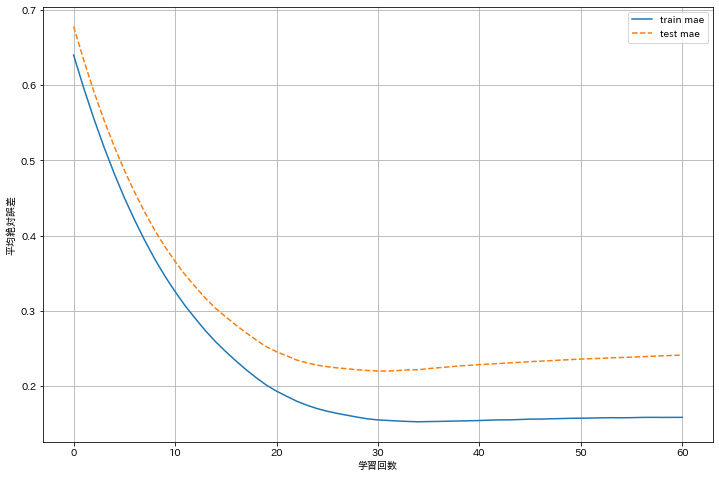

In [43]:
plt.figure(figsize=(12, 8))
train_metric = evals_result['train']['mae']
plt.plot(train_metric, label='train mae')
eval_metric = evals_result['test']['mae']
plt.plot(eval_metric, label='test mae', linestyle='dashed')
plt.grid()
plt.legend()
plt.xlabel('学習回数')
plt.ylabel('平均絶対誤差')
plt.savefig('kodate_learning_curve.png')
plt.show()

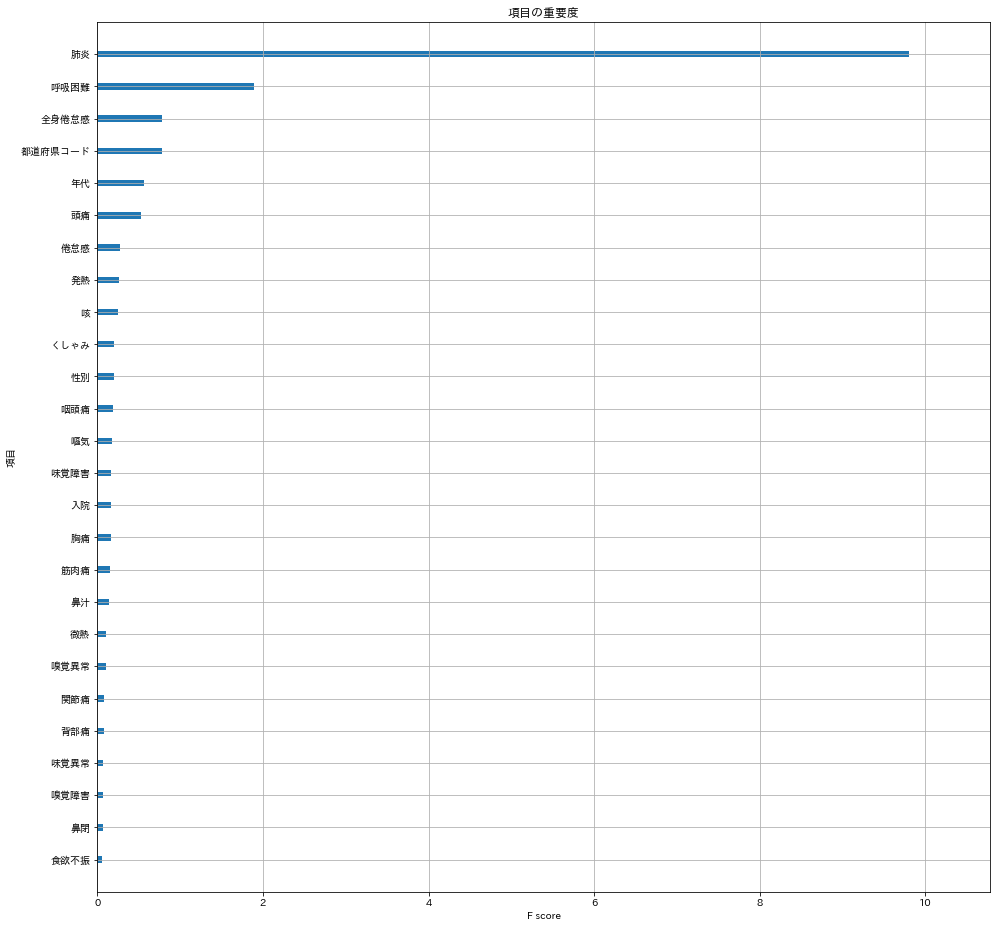

In [44]:
_, ax = plt.subplots(figsize=(16, 16))
xgb.plot_importance(model, ax=ax,  importance_type='gain', title='項目の重要度',show_values=False)
plt.ylabel("項目")
plt.savefig('kodate_feature.png')
plt.show()

## 東京のみの場合

In [45]:
df_new_tokyo = df_new[df_new["都道府県コード"] == 13]

In [46]:
df_train, df_test = train_test_split(df_new_tokyo, test_size=0.3, random_state=0)

y_train = df_train['ステータス']
y_test = df_test['ステータス']
x_train = df_train.drop(['ステータス'], axis=1)
x_test = df_test.drop(['ステータス'], axis=1)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [47]:
df_train['ステータス'].value_counts()

1    135
2      5
4      3
Name: ステータス, dtype: int64

In [48]:
params = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}
evals = [(dtrain, 'train'), (dtest, 'test')]

evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=30,
    evals_result=evals_result,
        )
clear_output()

In [49]:
y_pred = model.predict(dtest)
y_true = y_test.values

print('誤差率 : {0:.4f} %'.format(mean_error_rate(y_pred, y_test)))

誤差率 : 9.3944 %


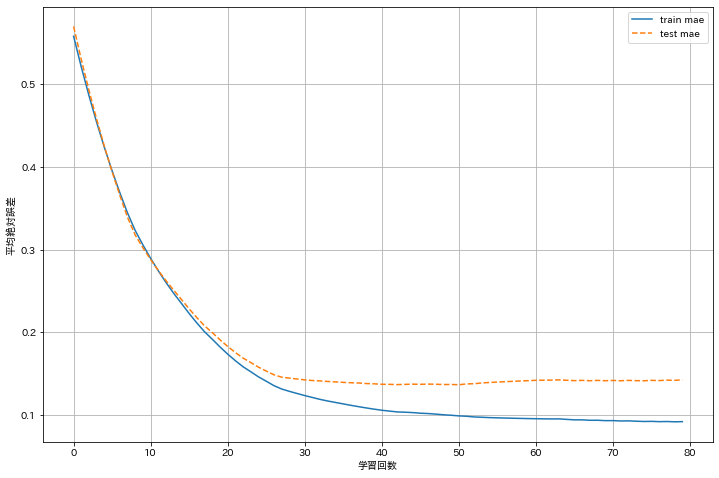

In [50]:
plt.figure(figsize=(12, 8))
train_metric = evals_result['train']['mae']
plt.plot(train_metric, label='train mae')
eval_metric = evals_result['test']['mae']
plt.plot(eval_metric, label='test mae', linestyle='dashed')
plt.grid()
plt.legend()
plt.xlabel('学習回数')
plt.ylabel('平均絶対誤差')
plt.savefig('kodate_learning_curve.png')
plt.show()

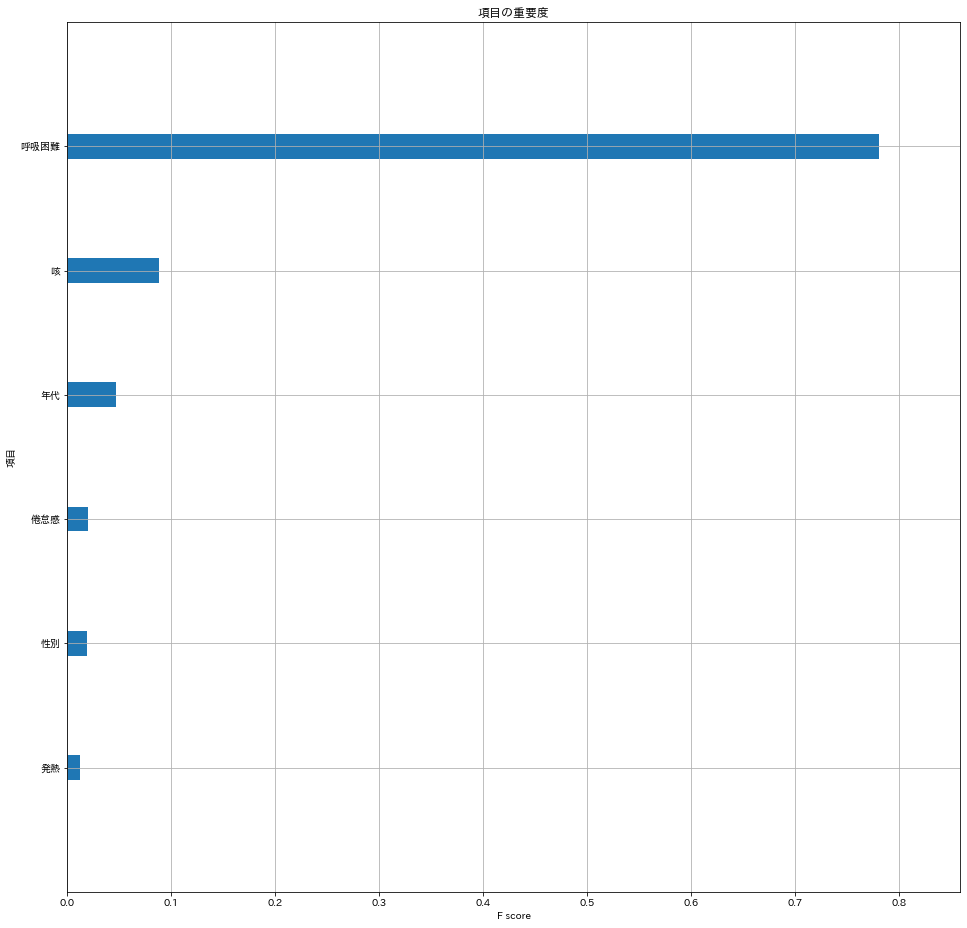

In [51]:
_, ax = plt.subplots(figsize=(16, 16))
xgb.plot_importance(model, ax=ax,  importance_type='gain', title='項目の重要度',show_values=False)
plt.ylabel("項目")
plt.savefig('kodate_feature.png')
plt.show()

## 神奈川のみの場合

In [52]:
df_new_kanagawa = df_new[df_new["都道府県コード"] == 14]

In [53]:
df_train, df_test = train_test_split(df_new_kanagawa, test_size=0.3, random_state=0)

y_train = df_train['ステータス']
y_test = df_test['ステータス']
x_train = df_train.drop(['ステータス'], axis=1)
x_test = df_test.drop(['ステータス'], axis=1)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [54]:
df_train['ステータス'].value_counts()

1    241
2     43
3     16
4      2
Name: ステータス, dtype: int64

In [55]:
params = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}
evals = [(dtrain, 'train'), (dtest, 'test')]

evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=30,
    evals_result=evals_result,
        )
clear_output()

In [56]:
y_pred = model.predict(dtest)
y_true = y_test.values

print('誤差率 : {0:.4f} %'.format(mean_error_rate(y_pred, y_test)))

誤差率 : 22.9770 %


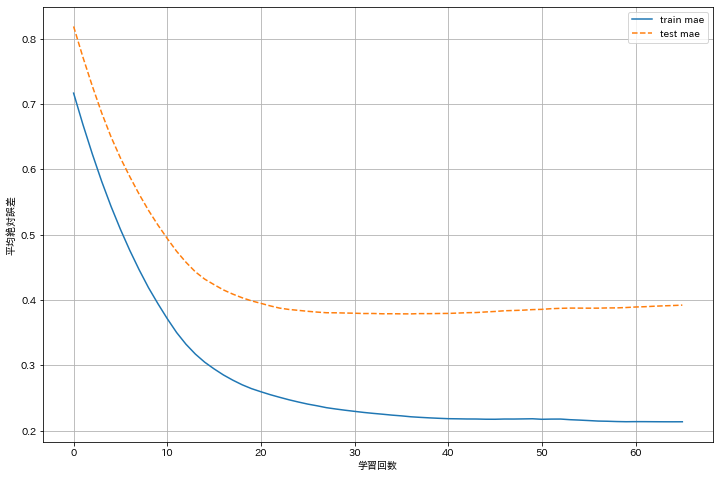

In [57]:
plt.figure(figsize=(12, 8))
train_metric = evals_result['train']['mae']
plt.plot(train_metric, label='train mae')
eval_metric = evals_result['test']['mae']
plt.plot(eval_metric, label='test mae', linestyle='dashed')
plt.grid()
plt.legend()
plt.xlabel('学習回数')
plt.ylabel('平均絶対誤差')
plt.savefig('kodate_learning_curve.png')
plt.show()

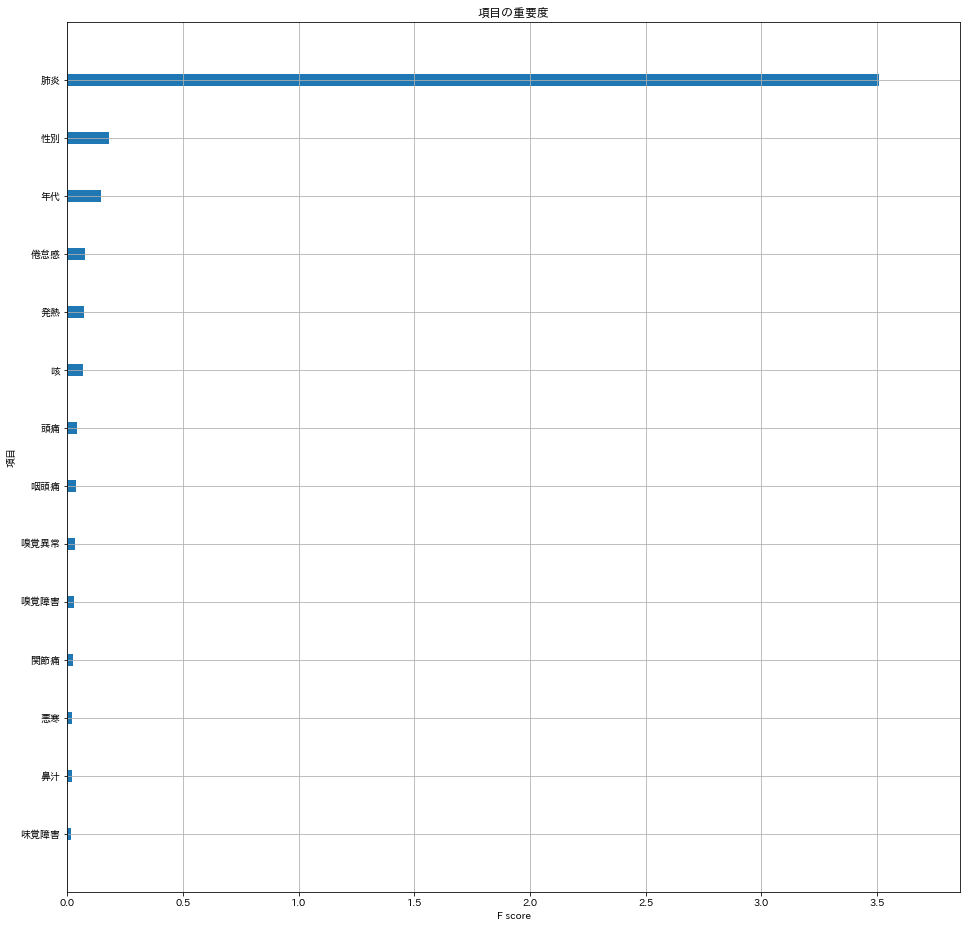

In [58]:
_, ax = plt.subplots(figsize=(16, 16))
xgb.plot_importance(model, ax=ax,  importance_type='gain', title='項目の重要度',show_values=False)
plt.ylabel("項目")
plt.savefig('kodate_feature.png')
plt.show()

## 北海道のみの場合

In [59]:
df_new_hokkaido = df_new[df_new["都道府県コード"] == 1]

In [60]:
df_train, df_test = train_test_split(df_new_hokkaido, test_size=0.3, random_state=0)

y_train = df_train['ステータス']
y_test = df_test['ステータス']
x_train = df_train.drop(['ステータス'], axis=1)
x_test = df_test.drop(['ステータス'], axis=1)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [61]:
df_train['ステータス'].value_counts()

1    349
2     35
3     12
4      2
Name: ステータス, dtype: int64

In [62]:
params = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}
evals = [(dtrain, 'train'), (dtest, 'test')]

evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=30,
    evals_result=evals_result,
        )
clear_output()

In [63]:
y_pred = model.predict(dtest)
y_true = y_test.values

print('誤差率 : {0:.4f} %'.format(mean_error_rate(y_pred, y_test)))

誤差率 : 18.0507 %


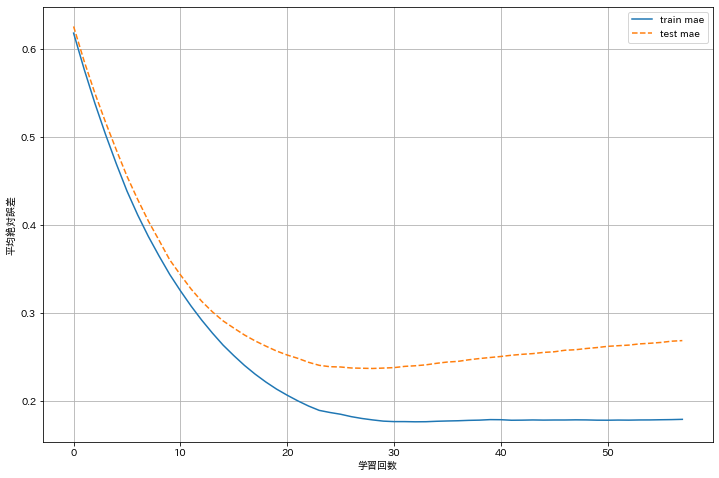

In [64]:
plt.figure(figsize=(12, 8))
train_metric = evals_result['train']['mae']
plt.plot(train_metric, label='train mae')
eval_metric = evals_result['test']['mae']
plt.plot(eval_metric, label='test mae', linestyle='dashed')
plt.grid()
plt.legend()
plt.xlabel('学習回数')
plt.ylabel('平均絶対誤差')
plt.savefig('kodate_learning_curve.png')
plt.show()

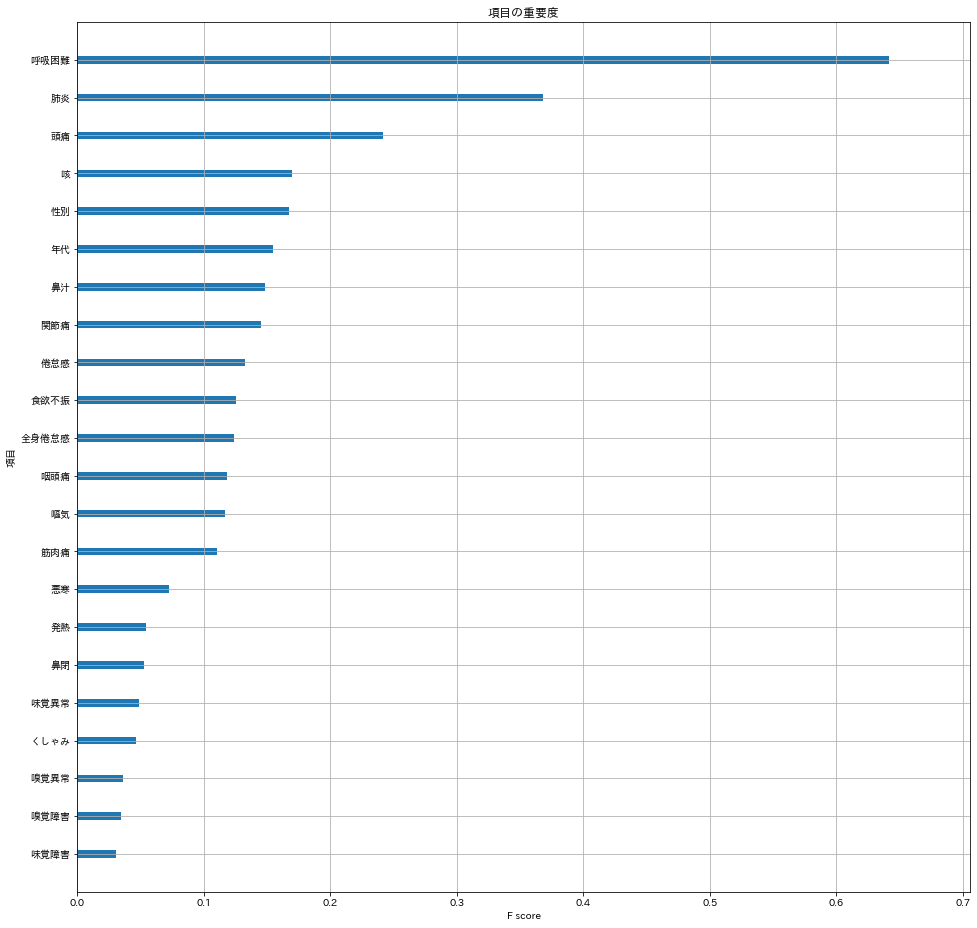

In [65]:
_, ax = plt.subplots(figsize=(16, 16))
xgb.plot_importance(model, ax=ax,  importance_type='gain', title='項目の重要度',show_values=False)
plt.ylabel("項目")
plt.savefig('kodate_feature.png')
plt.show()